In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

https://pytorch.org/tutorials/beginner/chatbot_tutorial.html?highlight=chatbot#define-evaluation

# Import

In [2]:
from pathlib import Path
import io

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchtext
from torchtext.vocab import build_vocab_from_iterator, GloVe
from nltk.translate import bleu

import torch
from torch import nn

from torch.utils.data import Dataset, DataLoader
from typing import List

/home/riyadh/codes/nlp/learn2ask/venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Look at Data
Data already preprocessed collected from the original repo.

In [3]:
data_root = Path("data/processed")

In [4]:
with open(data_root / "src-train.txt") as f:
    src_train = [line.strip() for line in f]

with open(data_root / "tgt-train.txt") as f:
    tgt_train = [line.strip() for line in f]

with open(data_root / "src-dev.txt") as f:
    src_dev = [line.strip() for line in f]

with open(data_root / "tgt-dev.txt") as f:
    tgt_dev = [line.strip() for line in f]

with open(data_root / "src-test.txt") as f:
    src_test = [line.strip() for line in f]

with open(data_root / "tgt-test.txt") as f:
    tgt_test = [line.strip() for line in f]

print(len(src_train), len(src_dev), len(src_test))

70484 10570 11877


# Vocabulary

In [5]:
import datahandler as dh

In [6]:
vocab = dh.load_and_build_vocab(
    data_root / "src-train.txt", data_root / "tgt-train.txt"
)

In [7]:
pad_index = vocab["<PAD>"]
sos_index = vocab["<SOS>"]
eos_index = vocab["<EOS>"]

In [8]:
# a tensor of shape (vocab_size, embedding_dim)
embedding_vector = dh.load_pretrained_glove(vocab, cache="data/")

# Batch Dataloader

In [9]:
config = {"src_max_seq": 150, "tgt_max_seq": 50, "batch_size": 32}

In [10]:
from tokenization import Tokenizer

In [65]:
tokenizer = Tokenizer(vocab, pad_index, sos_index, eos_index)

src_train_tensor, src_train_mask = tokenizer.encode(
    src_train, max_seq=config["src_max_seq"]
)

tgt_train_tensor, tgt_train_mask = tokenizer.encode(
    tgt_train, add_sos=True, add_eos=True, max_seq=config["tgt_max_seq"]
)

src_test_tensor, _ = tokenizer.encode(src_test, max_seq=config["src_max_seq"])
tgt_test_tensor, _ = tokenizer.encode(
    tgt_test, add_sos=True, add_eos=True, max_seq=config["tgt_max_seq"]
)

src_dev_tensor, src_dev_mask = tokenizer.encode(src_dev, max_seq=config["src_max_seq"])
tgt_dev_tensor, tgt_dev_mask = tokenizer.encode(
    tgt_dev, add_sos=True, add_eos=True, max_seq=config["tgt_max_seq"]
)

In [13]:
tokenizer.decode(src_train_tensor[0].unsqueeze(dim=0), keep_specials=False)

['a pub / <UNK> / , or public house is , despite its name , a private house , but is called a public house because it is licensed to sell alcohol to the general public .']

In [14]:
src_train[0]

'a pub / pʌb / , or public house is , despite its name , a private house , but is called a public house because it is licensed to sell alcohol to the general public .'

In [84]:
src_train_mask.shape

torch.Size([70484, 150])

In [85]:
class SentenceQuestionDataset(Dataset):
    def __init__(
        self,
        sentences: torch.Tensor,
        questions: torch.Tensor,
        sentences_mask=None,
        questions_mask=None,
    ):
        """
        Represents a dataset of text pairs for training or evaluating models that
        deal with relationships between text passages.

        Args:
            vocab (torchtext.vocab.Vocab): A pre-built vocabulary object
                containing word mappings from text to numerical representation.
            sentences (List[str]): A list of text passages (sentences, paragraphs, etc.).
            questions (List[str]): A list of corresponding questions related to the sentences.
            Ls (int, optional): The maximum length to which sentences will be
                truncated or padded during preprocessing (default: 150).
            Lq (int, optional): The maximum length to which questions will be
                truncated or padded during preprocessing (default: 50).
        """
        self.sentences = sentences
        self.questions = questions
        self.sentences_mask = sentences_mask
        self.questions_mask = questions_mask

    def __len__(self):
        return self.sentences.size(0)

    def __getitem__(self, index):
        return (
            self.sentences[index],
            self.questions[index],
            self.sentences_mask[index],
            self.questions_mask[index],
        )

In [86]:
train_ds = SentenceQuestionDataset(
    src_train_tensor, tgt_train_tensor, src_train_mask, tgt_train_mask
)
test_ds = SentenceQuestionDataset(src_test_tensor, tgt_train_tensor, None, None)
dev_ds = SentenceQuestionDataset(
    src_dev_tensor, tgt_dev_tensor, src_dev_mask, tgt_dev_mask
)

In [87]:
train_dl = DataLoader(train_ds, batch_size=config["batch_size"], shuffle=True)
print(len(train_dl))
dev_dl = DataLoader(dev_ds, batch_size=8, shuffle=False)

2203


# Models

In [18]:
from models import Encoder, Decoder, Seq2SeqEncoderDecoder

# Trainer

In [19]:
from trainer import Trainer

In [91]:
config["lr"] = 1.0
net = Seq2SeqEncoderDecoder(
    len(vocab),
    embedding_vector,
    300,
    vocab["<PAD>"],
    vocab["<SOS>"],
    vocab["<EOS>"],
    8,
    True,
)
optim = torch.optim.SGD(net.parameters(), lr=config["lr"])

trainer = Trainer(
    net,
    optim,
    train_dl,
    len(vocab),
    config["lr"],
    dev_dl,
    enable_checkpoint=True,
    limit_on_train_batch=2,
    enable_comet=True,
    comet_project="learn-to-ask-paper",
    comet_experiment_name=None,
    cfg=config,
    validation_data=tgt_dev,
    tokenizer=tokenizer,
)

trainer.fit(10)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/riyadhrazzaq/learn-to-ask-paper/abbbacfc8d1c4c72a9b02ff62e47631b

  0%|                                                                                                                                                | 0/1322 [00:00<?, ?it/s]/home/riyadh/codes/nlp/learn2ask/venv/lib64/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/riyadh/codes/nlp/learn2ask/venv/lib64/python3.

Epoch: 1,	Training loss: 10.845547676086426,	Validation metric: 6.1998595143978194e-232	Time elapsed: 6.36 s


  0%|                                                                                                                        | 2/2203 [00:06<2:02:33,  3.34s/batch, loss=10.7]


Epoch: 2,	Training loss: 10.722482045491537,	Validation metric: 0	Time elapsed: 6.93 s


  0%|                                                                                                                        | 2/2203 [00:05<1:45:54,  2.89s/batch, loss=10.5]


Epoch: 3,	Training loss: 10.590007464090982,	Validation metric: 0	Time elapsed: 6.00 s


  0%|                                                                                                                        | 2/2203 [00:05<1:46:23,  2.90s/batch, loss=10.3]


Epoch: 4,	Training loss: 10.381159782409668,	Validation metric: 0	Time elapsed: 6.03 s


  0%|                                                                                                                          | 2/2203 [00:05<1:48:31,  2.96s/batch, loss=10]


Epoch: 5,	Training loss: 10.133914947509766,	Validation metric: 0	Time elapsed: 6.13 s


  0%|                                                                                                                        | 2/2203 [00:05<1:49:20,  2.98s/batch, loss=9.64]


Epoch: 6,	Training loss: 9.769601186116537,	Validation metric: 0	Time elapsed: 6.22 s


  0%|                                                                                                                        | 2/2203 [00:05<1:48:55,  2.97s/batch, loss=9.22]


Epoch: 7,	Training loss: 9.301833470662435,	Validation metric: 0	Time elapsed: 6.18 s


  0%|                                                                                                                        | 2/2203 [00:05<1:49:32,  2.99s/batch, loss=8.85]


Epoch: 8,	Training loss: 8.941880544026693,	Validation metric: 0	Time elapsed: 6.22 s


  0%|                                                                                                                         | 2/2203 [00:05<1:48:38,  2.96s/batch, loss=8.6]


Epoch: 9,	Training loss: 8.646960894266764,	Validation metric: 0	Time elapsed: 6.14 s


  0%|                                                                                                                        | 2/2203 [00:05<1:49:01,  2.97s/batch, loss=8.48]
COMET INFO: ---------------------------------------------------------------------------------------                                                           
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/riyadhrazzaq/learn-to-ask-paper/abbbacfc8d1c4c72a9b02ff62e47631b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train/loss [10] : (8.559327125549316, 10.845547676086426)
COMET INFO:     val/bleu [10]   : (0, 6.1998595143978194e-232)
COMET INFO:     val/loss [10]   : (8.12829303741455, 10.752696990966797)
COMET INFO:   Others:
COMET INFO:     Name : None
COMET INFO:   Parameters:
COMET INF

Epoch: 10,	Training loss: 8.559327125549316,	Validation metric: 0	Time elapsed: 6.16 s


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


# Working trainer method

  0%|                                                                                                                                  | 0/2203 [00:01<?, ?batch/s, loss=10.8]

torch.Size([32, 49]) torch.Size([32, 50]) torch.Size([32, 49])


  0%|                                                                                                                        | 1/2203 [00:03<1:57:44,  3.21s/batch, loss=10.8]

torch.Size([32, 49]) torch.Size([32, 50]) torch.Size([32, 49])


  0%|                                                                                                                        | 2/2203 [00:06<1:38:16,  2.68s/batch, loss=10.7]

torch.Size([32, 49]) torch.Size([32, 50]) torch.Size([32, 49])


  0%|▏                                                                                                                       | 3/2203 [00:08<1:28:30,  2.41s/batch, loss=10.7]

torch.Size([32, 49]) torch.Size([32, 50]) torch.Size([32, 49])


  0%|▏                                                                                                                       | 4/2203 [00:10<1:24:16,  2.30s/batch, loss=10.6]

torch.Size([32, 49]) torch.Size([32, 50]) torch.Size([32, 49])


  0%|▎                                                                                                                       | 5/2203 [00:12<1:24:12,  2.30s/batch, loss=10.6]

torch.Size([32, 49]) torch.Size([32, 50]) torch.Size([32, 49])


  0%|▎                                                                                                                       | 6/2203 [00:15<1:25:22,  2.33s/batch, loss=10.5]

torch.Size([32, 49]) torch.Size([32, 50]) torch.Size([32, 49])


  0%|▎                                                                                                                       | 6/2203 [00:16<1:40:07,  2.73s/batch, loss=10.5]


epoch 1 loss 12.456178029378256


  0%|                                                                                                                                  | 0/2203 [00:00<?, ?batch/s, loss=10.5]

torch.Size([32, 49]) torch.Size([32, 50]) torch.Size([32, 49])


  0%|                                                                                                                        | 1/2203 [00:02<1:12:22,  1.97s/batch, loss=10.4]

torch.Size([32, 49]) torch.Size([32, 50]) torch.Size([32, 49])


  0%|                                                                                                                        | 2/2203 [00:04<1:14:15,  2.02s/batch, loss=10.3]

torch.Size([32, 49]) torch.Size([32, 50]) torch.Size([32, 49])


  0%|▏                                                                                                                       | 3/2203 [00:06<1:17:22,  2.11s/batch, loss=10.2]

torch.Size([32, 49]) torch.Size([32, 50]) torch.Size([32, 49])


  0%|▏                                                                                                                       | 4/2203 [00:09<1:18:18,  2.14s/batch, loss=10.1]

torch.Size([32, 49]) torch.Size([32, 50]) torch.Size([32, 49])


  0%|▎                                                                                                                       | 5/2203 [00:11<1:17:42,  2.12s/batch, loss=9.99]

torch.Size([32, 49]) torch.Size([32, 50]) torch.Size([32, 49])


  0%|▎                                                                                                                       | 6/2203 [00:13<1:17:27,  2.12s/batch, loss=9.95]

torch.Size([32, 49]) torch.Size([32, 50]) torch.Size([32, 49])


  0%|▎                                                                                                                       | 6/2203 [00:14<1:29:23,  2.44s/batch, loss=9.95]

epoch 2 loss 11.93348773320516


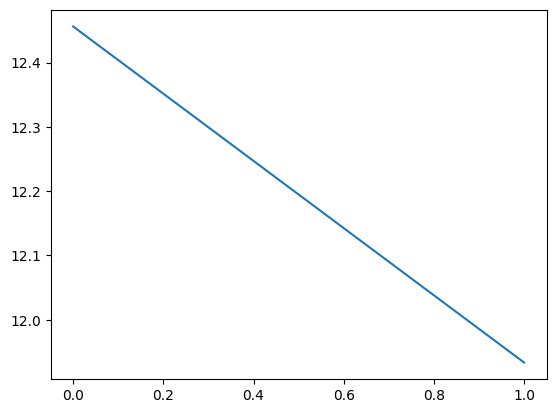

In [90]:
def train_epoch(model, optimizer, max_step=float("inf")):
    criterion = nn.CrossEntropyLoss(reduction="none")
    total_loss = 0
    bar = tqdm(train_dl, unit="batch")

    for step, data in enumerate(bar):
        optimizer.zero_grad()
        logits, scores = model(data[0], data[1][:, :-1])
        final_logits = torch.cat(logits, dim=0).view(
            logits[0].size(0), -1, logits[0].size(1)
        )

        loss = criterion(final_logits.transpose(1, 2), data[1][:, 1:])
        print(loss.shape, data[3].shape, data[3][:, 1:].shape)
        loss = loss.masked_select(data[3][:, 1:]).mean()

        bar.set_postfix(**{"loss": loss.item()})

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # early exit, needed during development
        if step > max_step:
            break

    return total_loss / step


model = Seq2SeqEncoderDecoder(
    len(vocab),
    embedding_vector,
    300,
    vocab["<PAD>"],
    vocab["<SOS>"],
    vocab["<EOS>"],
    8,
    True,
)
optim = torch.optim.SGD(model.parameters(), lr=1.0)

losses = []
for i in range(1, 3):
    loss = train_epoch(model, optim, max_step=5)
    print("epoch", i, "loss", loss)
    losses.append(loss)

plt.plot(losses)

In [35]:
source = next(iter(dev_dl))

In [45]:
outputs = model.generate(source[0])[0]
outputs = tokenizer.decode(outputs, keep_specials=False)

In [39]:
from nltk.translate.bleu_score import corpus_bleu

In [57]:
corpus_bleu(list_of_references=tgt_dev[0:8], hypotheses=outputs)

0

In [60]:
a = torch.ones((5, 3))
a[:, 2] = a[:, 2] / 5
a[]

tensor([[1.0000, 1.0000, 0.2000],
        [1.0000, 1.0000, 0.2000],
        [1.0000, 1.0000, 0.2000],
        [1.0000, 1.0000, 0.2000],
        [1.0000, 1.0000, 0.2000]])

In [72]:
tgt_dev

['which nfl team represented the afc at super bowl 50 ?',
 'which nfl team represented the nfc at super bowl 50 ?',
 'where did super bowl 50 take place ?',
 'which nfl team won super bowl 50 ?',
 'what color was used to emphasize the 50th anniversary of the super bowl ?',
 'what was the theme of super bowl 50 ?',
 'what day was the game played on ?',
 'what is the afc short for ?',
 'what was the theme of super bowl 50 ?',
 'what does afc stand for ?',
 'what day was the super bowl played on ?',
 'who won super bowl 50 ?',
 'what venue did super bowl 50 take place in ?',
 'what city did super bowl 50 take place in ?',
 'if roman numerals were used , what would super bowl 50 have been called ?',
 'super bowl 50 decided the nfl champion for what season ?',
 'what year did the denver broncos secure a super bowl title for the third time ?',
 'what city did super bowl 50 take place in ?',
 'what stadium did super bowl 50 take place in ?',
 'what was the final score of super bowl 50 ?',
 'w